In [2]:
import numpy as np
import tensorflow as tf
import math, os, sys

C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\keypg\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
dataset = np.load('dataset/stock_dataset_preprocessed.npz')
features, labels = dataset['features'][:, :, :4].astype('float32'), dataset['labels'].astype('float32')
input_shape = features.shape
train_test_split_factor = .8
validation_split_factor = .2
train_x, train_y, test_x, test_y = features[:math.floor(len(features)*train_test_split_factor)], labels[:math.floor(len(labels)*train_test_split_factor)], features[math.floor(len(features)*train_test_split_factor):], labels[math.floor(len(labels)*train_test_split_factor):]
train_x, test_x = np.expand_dims(train_x, axis=1), np.expand_dims(test_x, axis=1) # for use with TimeDistributed
#train_y, test_y = np.expand_dims(train_y, axis=1), np.expand_dims(test_y, axis=1) # for use with TimeDistributed
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(288, 1, 7, 4) (288, 7) (72, 1, 7, 4) (72, 7)


In [5]:
#layers = [
#    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='linear', input_shape=input_shape[1:])),
#    tf.keras.layers.Reshape((1, 7))
#]
layers = [
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', input_shape=input_shape[1:])),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(7, 3, padding='same', activation='relu', dilation_rate=2)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(14, 3, padding='same', activation='relu', dilation_rate=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(36, 3, padding='same', activation='relu', dilation_rate=1)),
    tf.keras.layers.Dense(70, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='linear')
]
model = tf.keras.models.Sequential(layers=layers)
#model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy', tf.keras.metrics.MeanSquaredError()])
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
#model.summary()

In [6]:
graph = model.fit(train_x, train_y, validation_split=validation_split_factor, epochs=250)
model.summary()

Epoch 1/250
8/8 [==============================] - 0s 48ms/step - loss: 1062714.6250 - accuracy: 0.1261 - val_loss: 68741.9062 - val_accuracy: 0.0345
Epoch 2/250
8/8 [==============================] - 0s 6ms/step - loss: 1056366.0000 - accuracy: 0.1261 - val_loss: 68044.5547 - val_accuracy: 0.0345
Epoch 3/250
8/8 [==============================] - 0s 6ms/step - loss: 1041295.9375 - accuracy: 0.1261 - val_loss: 66235.8359 - val_accuracy: 0.0345
Epoch 4/250
8/8 [==============================] - 0s 6ms/step - loss: 998412.6875 - accuracy: 0.1261 - val_loss: 61601.5000 - val_accuracy: 0.0345
Epoch 5/250
8/8 [==============================] - 0s 6ms/step - loss: 908007.2500 - accuracy: 0.1261 - val_loss: 50389.3633 - val_accuracy: 0.0345
Epoch 6/250
8/8 [==============================] - 0s 6ms/step - loss: 668071.3125 - accuracy: 0.1174 - val_loss: 26512.9844 - val_accuracy: 0.1379
Epoch 7/250
8/8 [==============================] - 0s 6ms/step - loss: 244450.2031 - accuracy: 0.1739 - val_

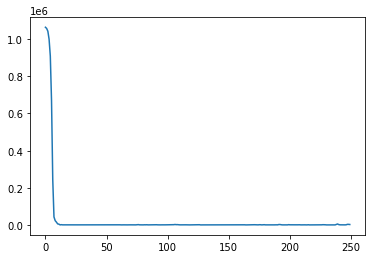

In [7]:
import matplotlib.pyplot as plt
loss = graph.history['loss']
val_loss = graph.history['val_loss']
val_acc = graph.history['val_accuracy']
plt.plot(range(len(loss)), loss)

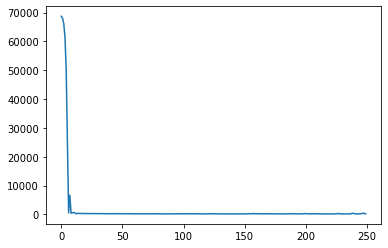

In [8]:
plt.plot(range(len(val_loss)), val_loss)

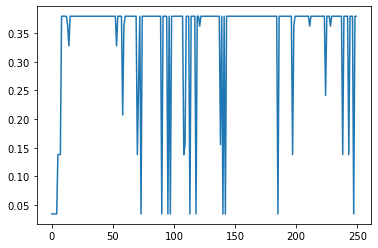

In [9]:
plt.plot(range(len(val_acc)), val_acc)

In [10]:
model.evaluate(test_x, test_y)

3/3 [==============================] - 0s 14ms/step - loss: 384.6962 - accuracy: 0.3889


[384.6961669921875, 0.3888888955116272]

In [16]:
pred = model.predict(test_x)

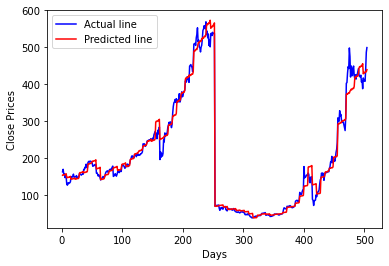

In [17]:
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

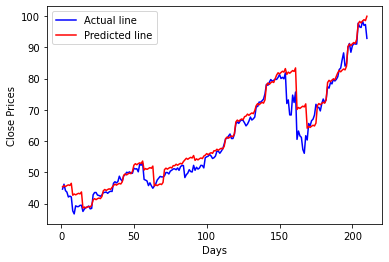

In [18]:
pred = model.predict(train_x[:30, :, :, :])
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(train_y[:30, :], (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

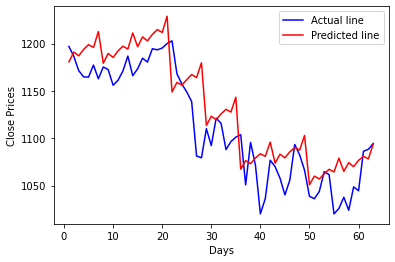

In [19]:
test_dataset = np.load('dataset/test_stock_preprocessed.npz')
test_stock_x, test_stock_y = test_dataset['features'][:, :, :4], test_dataset['labels']
test_stock_x = np.expand_dims(test_stock_x, axis=1)
pred = model.predict(test_stock_x)
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_stock_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()

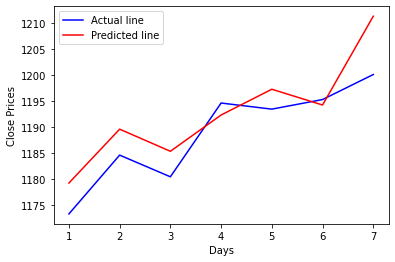

In [20]:
test_dataset = np.load('dataset/test_stock_preprocessed.npz')
test_stock_x, test_stock_y = test_dataset['features'][1, :, :4], test_dataset['labels'][2, :]
test_stock_x = np.expand_dims(test_stock_x, axis=0)
test_stock_x = np.expand_dims(test_stock_x, axis=0)
test_stock_y = np.expand_dims(test_stock_y, axis=0)
pred = model.predict(test_stock_x)
close_pred = np.reshape(pred, (-1, 1))
test_y_reshape = np.reshape(test_stock_y, (-1, 1))
days = np.arange(1, len(test_y_reshape)+1)
plt.plot(days, test_y_reshape, 'b', label='Actual line')
plt.plot(days, close_pred, 'r', label='Predicted line')
plt.xlabel('Days')
plt.ylabel('Close Prices')
plt.legend()
plt.show()